In [1]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax
import jax.numpy as jnp

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

(array([[-0.33041807, -0.36650581, -0.85626947],
       [ 0.75145792, -0.79022334, -0.09383658],
       [-0.87763452, -0.89065082,  0.82977779]]), array([[ 0.43435539, -0.17127215, -0.91127844],
       [-0.45193036, -0.60119803, -0.38274931],
       [-0.15230833,  0.49656568, -0.84528719]]), array([[1.96040957, 0.        , 0.        ],
       [0.        , 0.92531966, 0.        ],
       [0.        , 0.        , 0.57379257]]), array([[ 5.60596536e-01,  8.32667268e-17, -1.38777878e-16],
       [ 8.32667268e-17,  5.60596536e-01, -1.80411242e-16],
       [-1.38777878e-16, -1.80411242e-16,  5.60596536e-01]]))


In [2]:
def logs(params, X, Y, out_dim):
    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    ni, no = w1.shape[1], w2.shape[0]
    w2w1 = w2 @ w1
    w1w1 = w1.T @ w1
    w2w2 = w2 @ w2.T
    ntk = jnp.kron(jnp.identity(no), X @ (w1.T @ w1) @ X.T) + jnp.kron(w2 @ w2.T, X @ X.T)
    return w2w1, w1w1, w2w2, ntk

logs = jax.jit(logs)

In [3]:
blind_colours = BlindColours().get_colours()

In [3]:
np.random.seed(3)

in_dim = 4
hidden_dim = 5
out_dim = 3

batch_size = 10
learning_rate = 0.05
training_steps = 10000

network_functions = []
w1w1s = []
w2w2s = []
ntks = []
lossess = []
analyticalss = []

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .25)
training_data, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])
X, Y = training_data(None)

for initial_weight_scale in [0.001, 0.15]:
    network_function = []
    w1w1 = []
    w2w2 = []
    ntk = []
    losses = []
    analyticals = np.zeros((training_steps, in_dim + out_dim, in_dim + out_dim))

    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_weight_scale)

    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    ni, no = w1.shape[1], w2.shape[0]
    network_function.append(w2 @ w1)
    w1w1.append(w1.T @ w1)
    w2w2.append(w2 @ w2.T)
    ntk.append(jnp.kron(jnp.identity(no), X @ (w1.T @ w1) @ X.T) + jnp.kron(w2 @ w2.T, X @ X.T))

    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        w2w1_, w1w1_, w2w2_, ntk_ = logs(params, X, Y, out_dim)
        network_function.append(w2w1_)
        w1w1.append(w1w1_)
        w2w2.append(w2w2_)
        ntk.append(ntk_)
        losses.append(loss)
    analytical = QQT(init_w1, init_w2, X.T, Y.T)
    
    for step in range(training_steps):
        analyticals[step] = analytical.forward(learning_rate)

    lossess.append(np.asarray(losses))
    network_functions.append(np.asarray(network_function))
    w1w1s.append(np.asarray(w1w1))
    w2w2s.append(np.asarray(w2w2))
    ntks.append(np.asarray(ntk))
    analyticalss.append(analyticals)

<Axes: >

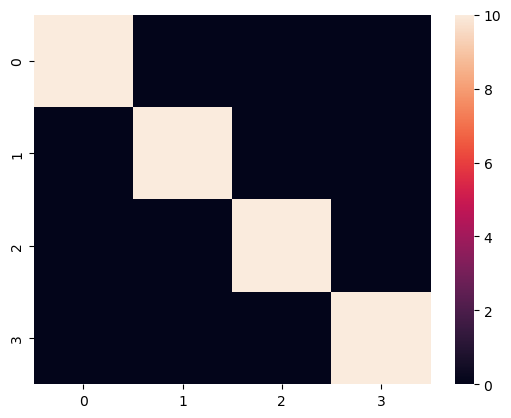

In [6]:
t = training_data(None)[0]

sns.heatmap(t.T @ t)


In [7]:
t.shape

(10, 4)

In [12]:
fig, axs_ = plt.subplots(2, 5, figsize=(14, 4.5), sharex=True)

for mode in range(2):
    axs = axs_[mode]
    
    axs[1].plot(network_functions[mode].reshape(-1, in_dim * out_dim), color=blind_colours[0])
    w2w1 = analyticalss[mode][:, in_dim:, :in_dim]
    axs[1].plot(w2w1.reshape(-1, in_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    #axs[1].set_ylim(-0.38, 0.3)
    #axs[1].set_yticks([ -0.2, 0., 0.2])
    axs[1].set_ylabel("$W_2W_1(t)$", fontsize=16)
    
    axs[0].plot(lossess[mode], color=blind_colours[6])
    loss = []
    loss = 0.5 * (out_dim / batch_size) * np.mean(np.sum((w2w1 @ X.T - Y.T)**2, axis=2), axis=1)
    axs[0].plot(loss, c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[0].set_ylim(-0.075, 0.8)
    axs[0].set_yticks([0., 0.25, 0.5, 0.75])
    axs[0].set_ylabel("Loss")
    
    
    axs[2].plot(w1w1s[mode].reshape(-1, in_dim * in_dim), color=blind_colours[2])
    w1w1 = analyticalss[mode][:, :in_dim, :in_dim]
    axs[2].plot(w1w1.reshape(-1, in_dim * in_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[2].set_ylim(-0.3, 1.2)
    axs[2].set_yticks([0., 0.5, 1.])
    axs[2].set_ylabel("$W_1^TW_1(t)$", fontsize=16)
    
    axs[3].plot(w2w2s[mode].reshape(-1, out_dim * out_dim), color=blind_colours[1])
    w2w2 = analyticalss[mode][:, in_dim:, in_dim:]
    axs[3].plot(w2w2.reshape(-1, out_dim * out_dim), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[3].set_ylim(-0.7, 1.1)
    axs[3].set_yticks([-0.5, 0., 0.5, 1.])
    axs[3].set_ylabel("$W_2W_2^T(t)$", fontsize=16)
    
    axs[4].plot(ntks[mode].reshape(-1, out_dim*batch_size * out_dim*batch_size), color=blind_colours[3])
    
    ntk = np.kron(np.identity(out_dim), np.einsum("ab,cbd,de->cae", X, w1w1, X.T)) + np.kron(w2w2, X@X.T) #  + np.einsum("a,bc,cd->abd", np.trace(, axis1=1, axis2=2), X, X.T)
    axs[4].plot(ntk.reshape(-1, out_dim*batch_size * out_dim*batch_size), c="k", alpha=0.7, linestyle=(0, (1, 2)))
    axs[4].set_ylabel("NTK$(t)$", fontsize=16)
    axs[4].set_ylim(-7, 8)
    axs[4].set_yticks([-5, 0, 5])
    
    if mode == 1:
        for i in range(5):
            axs[i].set_xlabel("Training Steps")
    axs[0].set_xscale("log")
    axs[0].set_xticks([1., 100, 10000])
sns.despine()
fig.tight_layout()

fig.savefig("./figures/figure-2_a-b.svg")

In [ ]:
trai

In [5]:
def loss_difference(loss1, loss2):
    return np.mean((loss1 - loss2)**2)

In [6]:
network_functions = []
lossess = []
all_losses = {}
all_analytical_losses = {}
deviations = {}

seeds_n = 50
max_training_steps = 20000
learning_rates = np.geomspace(0.05, 0.0005, 7)

for seed in range(seeds_n):
    print("Run", seed, end="\r")
    np.random.seed(seed)
    
    in_dim = np.random.randint(2, 51)
    out_dim = np.random.randint(2, 51)
    if in_dim == out_dim:
        out_dim += 1
    hidden_dim = np.random.randint(np.min([in_dim, out_dim]), 51)
    max_dim = np.max([in_dim, out_dim, hidden_dim])
    batch_size = np.random.randint(max_dim * 2, max_dim * 3)

    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    X, Y = training_data(None)
    
    # Initial weights
    denom = np.sqrt(max_dim)
    sigma = np.random.uniform(0.01 / denom, .5 / denom)
    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, sigma)

    deviations[seed] = {}
    all_losses[seed] = {}
    all_analytical_losses[seed] = {}
    
    for j, learning_rate in enumerate(learning_rates):
        last_loss = -1
        
        all_losses[seed][j] = []
        all_analytical_losses[seed][j] = []
        deviations[seed][j] = []
        
        task = gs.tasks.FullBatchLearning(training_data)
        optimiser = gs.GradientDescent(learning_rate)
        loss = gs.MeanSquaredError()

        losses = []

        mlp = gs.Network([
            gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
            gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
        ])

        trainer = gs.Trainer(task, mlp, loss, optimiser)
        state, params = gs.assemble(1, seed)

        for training_step in range(max_training_steps):
            state, params, loss = trainer(state, params)
            losses.append(loss)
            
            if training_step == 0:
                initial_loss = loss
            
            if np.abs(last_loss - loss) < 1e-15 and loss < initial_loss - 0.02 and training_step > 10000:
                break
            last_loss = loss
        training_step += 1
        
        analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
        analyticals = np.zeros((training_step, out_dim, in_dim))
        for step in range(training_step):
            analyticals[step] = analytical.forward(learning_rate)
        w2w1 = np.asarray(analyticals)
        
        analytical_losses = 0.5 * (out_dim / batch_size) * np.mean(np.sum((w2w1 @ X.T - Y.T)**2, axis=2), axis=1)
        analytical_losses = np.asarray(analytical_losses)
        all_analytical_losses[seed][j].append(analytical_losses)
        
        losses = np.asarray(losses)[:, 0]
        all_losses[seed][j].append(losses)
        
        deviations[seed][j].append(loss_difference(losses, analytical_losses))

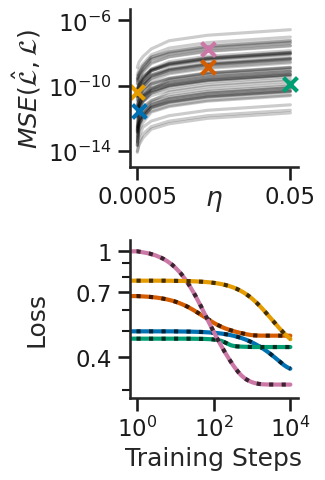

In [ ]:
np.random.seed(2)

fig, axs = plt.subplots(2, 1, figsize=(3.55, 5.15))
for seed in range(seeds_n):
    dev = [deviations[seed][j] for j, _ in enumerate(learning_rates)]
    if seed in []: # 1, 2, 6
        axs[0].plot(learning_rates, dev, c=blind_colours[seed], alpha=0.8, zorder=3)
    else:
        axs[0].plot(learning_rates, dev, c=blind_colours[7], alpha=0.2, zorder=2)
axs[0].set_yscale("log")
axs[0].set_ylim([0.000000000000001, 0.000005])
axs[0].set_yticks([1e-6, 1e-10, 1e-14])
axs[0].set_xticks([0.0005, 0.05])
axs[0].set_xticklabels(["0.0005", "0.05"])
axs[0].set_xlabel("$\eta$", fontsize=19, labelpad=-15)
axs[0].set_ylabel("$MSE(\\hat{\\mathcal{L}}, \\mathcal{L})$", fontsize=18)

for i, seed in enumerate(np.random.choice(seeds_n, 5, replace=False)):
    lr = np.random.choice(7)
    color = blind_colours[i]
    axs[0].scatter(learning_rates[lr], deviations[seed][lr], c=[color], zorder=2, marker="x", s=100, lw=3.)
    axs[1].plot(all_losses[seed][lr][0][:10000], c=color, lw=3.)
    axs[1].plot(all_analytical_losses[seed][lr][0][:10000], c="k", alpha=0.7, lw=3., linestyle=(0, (1, 2)))

axs[1].loglog()
axs[1].set_xticks([1, 100, 10000])
axs[1].set_ylim([0.28, 1.1])
axs[1].set_yticks([1., 0.7, 0.4])
axs[1].set_yticklabels([1, 0.7, 0.4])
axs[1].set_xlabel("Training Steps")
axs[1].set_ylabel("Loss", labelpad=20)
axs[1].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

fig.tight_layout()
sns.despine()

fig.savefig("./figures/figure-2_c-d.svg")

In [ ]:
#TODO:

#1. Define Forgetting Formula.

#2. Do Gradient Descent and Plot Forgetting

#3. Plot Forgetting using QQt

#4. Plot rate of forgetting using Gradient Descent

#5. Plot rate of forgetting using QQt

In [ ]:
#Defining the forgetting Formula


#Forgetting F on task T_i when training on task T_k after having trained the network on task T_j
#F_i(T_j, T_k) = L_i(T_k) - L_i(T_j)

def loss(W1, W2, X, Y):
    return 0.5 * (out_dim / batch_size) * np.mean(np.sum((W2 @ W1 @ X - Y)**2, axis=0))

def forgetting(W1, W2, Xj, Yj, Xk, Yk):
    return loss(W1, W2, Xk, Yk) - loss(W1, W2, Xj, Yj)

In [8]:
def train_network(train, learning_rate, in_dim, hidden_dim, out_dim, init_w1, init_w2, training_steps):


    task = gs.tasks.FullBatchLearning(train)


    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    # init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, 0.5)

    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)
    losses = []
    ws = []

    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]

    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])

    return losses, ws


In [7]:
def computationalSolution(qqtTask):
    # Now, generate the computational solution
    losses, ws = train_network(train=qqtTask.train,
                               learning_rate=qqtTask.learning_rate,
                               in_dim=qqtTask.in_dim,
                               hidden_dim=qqtTask.hidden_dim,
                               out_dim=qqtTask.out_dim,
                               init_w1=qqtTask.init_w1,
                               init_w2=qqtTask.init_w2,
                               training_steps=qqtTask.training_steps)

    return losses, ws




In [ ]:
"""
Now that we have the formulae defined, we just have to implement the computational solution 
using gradient descnet and the analytical QQt and store the forgetting for each task.
"""
#initialise network, train using GD

initial_scale = 0.5

w1_i, w2_i = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale * 2)
w1_j, w2_j = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale * 2)
w1_k, w2_k = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale * 2)

train, _, _ = gs.datasets.StudentTeacher(batch_size, [w1_k, w2_k], [gs.datasets.Whiten()])

losses, ws = train_network(train=)


print everything

